In [ ]:
from rl_opts.virtual_abm import virtual_ABM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm.notebook import tqdm

from rl_opts.virtual_abm import get_ABM_motion


def moving_average(a, n=3) :
    if len(a.shape) == 1:
        d1 = True        
        a = a[np.newaxis, :]
    else:
        d1 = False
    ret = np.cumsum(a, axis = 1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    if d1:
        return ret[0, n - 1:] / n
    else:
        return ret[:, n - 1:] / n

# Params

In [ ]:
# Physical parameters
L = 1
tau = 1

Pe = 26 # Péclet number
ell = 1 # Dimensionless persistence length
r = 0.21 # Size of the target

dt = 0.001600000



v = Pe * L / tau  # self-propulsion velocity
D_theta = v/ell
D = L*L/(4*tau);
vdt = v*dt 
sigma = np.sqrt(2*D*dt); # sigma for translational
sigma_theta = np.sqrt(2*D_theta*dt) # sigma for rotational


# Training parameters
N_episodes = int(1e3)
Nt_single_episode = int(0.8*N_episodes)

gamma = 1e-9
eta =  1e-2

pBP =  1e-2  # initial probability of changing when passive
pABP =  1e-4 # initial probability of changing when active

In [ ]:
wrap = virtual_ABM(L = L, r = r,
                   num_episodes = None,
                   time_ep = Nt_single_episode,
                   gamma_damping = gamma, 
                   eta_glow_damping = eta 
                  ) 

wrap.agent.h_matrix[1, ::2] = pBP / (1-pBP)
wrap.agent.h_matrix[1, 1::2] = pABP / (1-pABP)

wrap.init_training()


# Let's save the position of the agent and targets at each time step and each episode, as well as its phase and rewards 
particle_pos = np.zeros((N_episodes, wrap.time_ep, 2))
target_pos = np.zeros((N_episodes, wrap.time_ep, 2))
phases = np.zeros((N_episodes, wrap.time_ep))
rewards = np.zeros((N_episodes, wrap.time_ep))
counter = np.zeros((N_episodes, wrap.time_ep))

# hmats = np.zeros((wrap.num_episodes, wrap.agent.h_matrix.shape[0], wrap.agent.h_matrix.shape[1]))

for epoch in tqdm(range(N_episodes)):

    wrap.init_virtual_env()

    # hmats[epoch] = wrap.agent.h_matrix.copy()

    # Initial phase of the agent. Note that the agent always starts in the passive phase. 
    phi =  wrap.current_phase
    # If you want to start in the active phase, you just need to set:
    wrap.current_phase = np.random.randint(2)  # This will randomly set the phase to either 0 or 1, but we start in passive phase
    # at the start of the code.
    
    # We set a random initial direction for the ABM generator
    theta = 2*np.pi*np.random.rand()     


    for t in range(wrap.time_ep):

        # Saving stuff
        particle_pos[epoch, t] = wrap.env.positions[0]
        target_pos[epoch, t] = wrap.env.target_positions[0]
        phases[epoch, t] = wrap.current_phase

        # Generating displacement via ABM
        x0, y0 = wrap.env.positions[0].copy()
        x1, y1, theta = get_ABM_motion(x0, y0, theta, phi, vdt, sigma, sigma_theta, L)

        # Now we send this to the wrapper. The step function can also give you the reward if asked:
        displacement = (x1-x0, y1-y0)
        action, reward = wrap.step(displacement, return_reward=True)

        # Update the phase for the ABM generator. This should be the input in the experiment to change phase too.
        if action == 1:
            phi = 1 - phi

        # And let's save the rewards (nothing different than zero to be expected here)
        rewards[epoch, t] = reward # minus ones are needed here because wrap.step already updated the epoch and t_ep

        counter[epoch, t] = wrap.agent.agent_state

    

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Average reward')

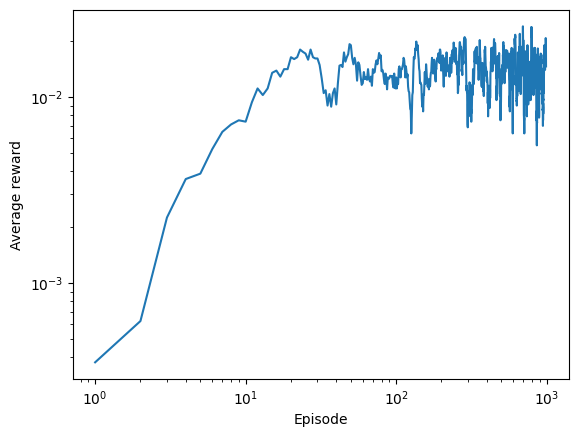

In [ ]:
plt.loglog(np.arange(epoch-9) +1, moving_average(rewards[:epoch].mean(-1), n = 10))
plt.xlabel('Episode')
plt.ylabel('Average reward')

## Grid search

In [ ]:

def train_loop_abm(gamma, eta):

    wrap = virtual_ABM(L = L, r = r,
                    num_episodes = None,
                    time_ep = Nt_single_episode,
                    gamma_damping = gamma, 
                    eta_glow_damping = eta 
                    ) 
                        

    wrap.agent.h_matrix[1, ::2] = pBP / (1-pBP)
    wrap.agent.h_matrix[1, 1::2] = pABP / (1-pABP)

    wrap.init_training()
    

    # Let's save the position of the agent and targets at each time step and each episode, as well as its phase and rewards 
    # particle_pos = np.zeros((N_episodes, wrap.time_ep, 2))
    # target_pos = np.zeros((N_episodes, wrap.time_ep, 2))
    # phases = np.zeros((N_episodes, wrap.time_ep))
    rewards = np.zeros((N_episodes, wrap.time_ep))
    # hmats = np.zeros((wrap.num_episodes, wrap.agent.h_matrix.shape[0], wrap.agent.h_matrix.shape[1]))

    for epoch in range(N_episodes):

        wrap.init_virtual_env()

        # hmats[epoch] = wrap.agent.h_matrix.copy()

        # Initial phase of the agent. Note that the agent always starts in the passive phase. 
        phi =  wrap.current_phase
        # If you want to start in the active phase, you just need to set:
        wrap.current_phase = np.random.randint(2)  # This will randomly set the phase to either 0 or 1, but we start in passive phase
        # at the start of the code.
        
        # We set a random initial direction for the ABM generator
        theta = 2*np.pi*np.random.rand()     


        for t in range(wrap.time_ep):

            # Saving stuff
            # particle_pos[epoch, t] = wrap.env.positions[0]
            # target_pos[epoch, t] = wrap.env.target_positions[0]
            # phases[epoch, t] = wrap.current_phase

            # Generating displacement via ABM
            x0, y0 = wrap.env.positions[0].copy()
            x1, y1, theta = get_ABM_motion(x0, y0, theta, phi, vdt, sigma, sigma_theta, L)

            # Now we send this to the wrapper. The step function can also give you the reward if asked:
            displacement = (x1-x0, y1-y0)
            action, reward = wrap.step(displacement, return_reward=True)

            # Update the phase for the ABM generator. This should be the input in the experiment to change phase too.
            if action == 1:
                phi = 1 - phi

            # And let's save the rewards (nothing different than zero to be expected here)
            rewards[epoch, t] = reward # minus ones are needed here because wrap.step already updated the epoch and t_ep


    return rewards, wrap.agent.h_matrix

    

In [ ]:
gammas = np.logspace(-10,-5,10)
etas = np.logspace(-3,-1,10)

N_episodes = int(1e4)


rewards = np.zeros((gammas.shape[0], etas.shape[0], N_episodes))
for idxg, gamma in enumerate(gammas):
    for idxe, eta in enumerate(etas):
        rews, _ = train_loop_abm(gamma, eta)

        rewards[idxg, idxe] = rews.mean(1)     



<matplotlib.colorbar.Colorbar>

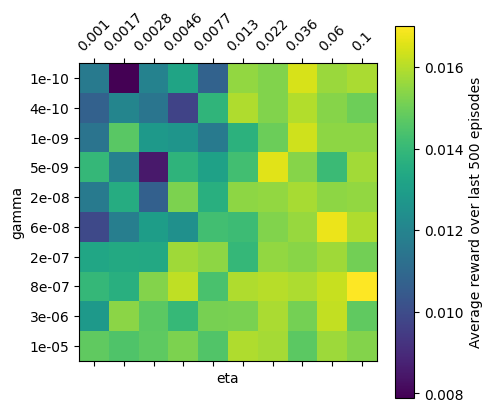

In [ ]:
plt.matshow(rewards[:,:,-500:].mean(-1))

plt.xlabel('eta')
plt.ylabel('gamma')
plt.xticks(ticks=np.arange(len(etas)), labels=[f"{e:.2g}" for e in etas], rotation=45)
plt.yticks(ticks=np.arange(len(gammas)), labels=[f"{g:.1g}" for g in gammas])
plt.colorbar(label ='Average reward over last 500 episodes')